✅ Директории созданы:
   - Данные: /home/evstigneva/nto25/baseline/data
   - Модели: /home/evstigneva/nto25/baseline/output/models
   - Результаты: /home/evstigneva/nto25/baseline/output/submissions
   - Исходные данные: /home/evstigneva/Zagr

🔍 Проверка файлов данных:
   ✅ train.csv - найден
   ✅ test.csv - найден
   ✅ users.csv - найден
   ✅ books.csv - найден
   ✅ book_genres.csv - найден
   ✅ genres.csv - найден
   ✅ book_descriptions.csv - найден
🎯 ШАГ 1: ПОДГОТОВКА ДАННЫХ
Пайплайн подготовки данных
Загрузка данных...
Отфильтровано тренировочных данных: 268581 -> 156179 строк (только has_read=1)
Данные загружены. Объединение датасетов...
Размер объединенных данных: (159073, 15)

Обработка данных по чанкам...
Обработка данных по частям: 159073 строк -> 2 чанков по ~100000 строк
Обработка чанка 1/2 (0:100000)
Запуск пайплайна инженерии фич...
Добавление фич жанров...
Добавление текстовых фич (TF-IDF)...
Загрузка существующего векторайзера из /home/evstigneva/nto25/baseline/output/mo

[I 2025-12-02 02:53:12,155] A new study created in memory with name: lgbm_hyperparam_optimization


Тренировочные фичи: 516

🚀 Запуск оптимизации гиперпараметров с Optuna
   Количество trials: 50
   Таймаут: 3600 секунд


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-02 03:07:30,875] Trial 0 finished with value: 2.855758828900894 and parameters: {'boosting_type': 'goss', 'num_leaves': 65, 'max_depth': 8, 'learning_rate': 0.0003487351559952693, 'feature_fraction': 0.49359671220172163, 'bagging_fraction': 0.4348501673009197, 'bagging_freq': 9, 'min_child_samples': 62, 'min_child_weight': 0.006796578090758156, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285, 'min_split_gain': 0.8324426408004217, 'subsample': 0.5274034664069657, 'colsample_bytree': 0.5090949803242604}. Best is trial 0 with value: 2.855758828900894.
[I 2025-12-02 03:12:52,332] Trial 1 finished with value: 2.8771113996432356 and parameters: {'boosting_type': 'goss', 'num_leaves': 22, 'max_depth': 7, 'learning_rate': 0.001029530064265006, 'feature_fraction': 0.7671117368334277, 'bagging_fraction': 0.4836963163912251, 'bagging_freq': 3, 'min_child_samples': 40, 'min_child_weight': 0.0006672367170464204, 'reg_alpha': 0.1165691561324743, 'reg_lambda': 6.267062

,user_id,book_id,has_read,rating,timestamp,source,gender,age,title,author_id,...,tfidf_490,tfidf_491,tfidf_492,tfidf_493,tfidf_494,tfidf_495,tfidf_496,tfidf_497,tfidf_498,tfidf_499
0,281,441829,1.0,10.0,2007-04-11 06:09:42,train,1,39.0,Фальшивые зеркала,226891,...,0.151255,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,281,168663,1.0,10.0,2007-04-11 06:10:12,train,1,39.0,Лабиринт отражений,226891,...,0.000000,0.0,0.0,0.236035,0.0,0.0,0.0,0.0,0.0,0.0
2,1851,431081,1.0,10.0,2007-11-26 23:25:24,train,1,36.0,Любовь живет три года,26123,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,3421,3903655,1.0,10.0,2008-03-25 16:40:46,train,2,36.0,Глубина: Лабиринт отражений. Фальшивые зеркала...,226891,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,2661,2599190,1.0,10.0,2008-09-02 09:44:40,train,2,49.0,Гарри Поттер и Философский камень,179700,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


📊 Статистика предсказаний:
Min: 2.0168
Max: 9.7691
Mean: 7.6312
Std: 1.1773


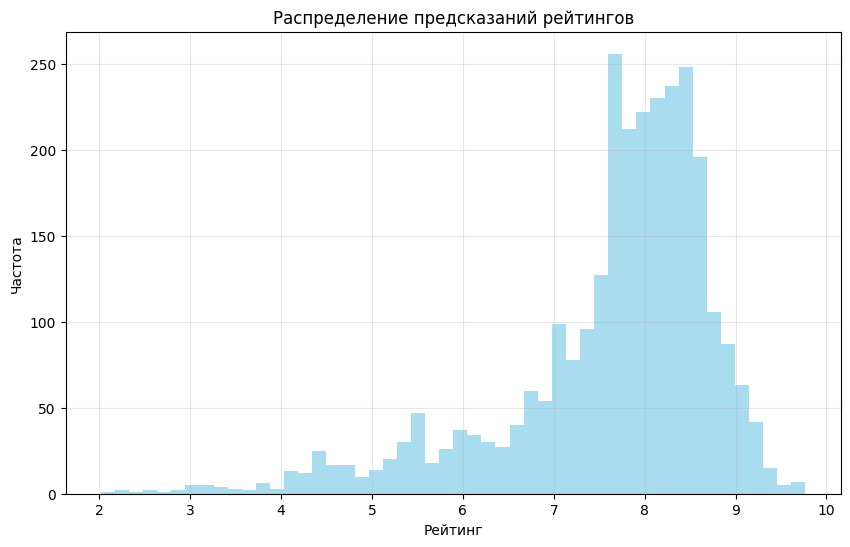

In [1]:
# nto25_notebook.ipynb

# %% [markdown]
# # NTO25 ML Competition Baseline
# Полный пайплайн для соревнования по машинному обучению

# %%
# Установка зависимостей (раскомментируйте при необходимости)
# !pip install lightgbm pandas numpy scikit-learn tqdm joblib pyarrow optuna

# %%
import sys
import time
from pathlib import Path
from typing import Any, Dict, List, Tuple, Optional, Union

import joblib
import lightgbm as lgb
import numpy as np
import optuna
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm

# %%
# =============================================================================
# КОНСТАНТЫ
# =============================================================================

# --- ФАЙЛЫ ---
# Используем абсолютные пути из оригинального кода
TRAIN_FILENAME = "/home/evstigneva/nto252/train.csv"
TEST_FILENAME = "/home/evstigneva/nto252/test.csv" 
USER_DATA_FILENAME = "/home/evstigneva/nto252/users.csv"
BOOK_DATA_FILENAME = "/home/evstigneva/nto252/books.csv"
BOOK_GENRES_FILENAME = "/home/evstigneva/nto252/book_genres.csv"
GENRES_FILENAME = "/home/evstigneva/nto252/genres.csv"
BOOK_DESCRIPTIONS_FILENAME = "/home/evstigneva/nto252/book_descriptions.csv"
SUBMISSION_FILENAME = "/home/evstigneva/nto252/submission30.11.25_7.csv"
TFIDF_VECTORIZER_FILENAME = "tfidf_vectorizer.pkl"
PROCESSED_DATA_FILENAME = "processed_features.parquet"

# --- НАЗВАНИЯ КОЛОНОК ---
COL_USER_ID = "user_id"
COL_BOOK_ID = "book_id"
COL_TARGET = "rating"
COL_SOURCE = "source"
COL_PREDICTION = "rating_predict"
COL_HAS_READ = "has_read"
COL_TIMESTAMP = "timestamp"

# Фичевые колонки (новые)
F_USER_MEAN_RATING = "user_mean_rating"
F_USER_RATINGS_COUNT = "user_ratings_count"
F_BOOK_MEAN_RATING = "book_mean_rating"
F_BOOK_RATINGS_COUNT = "book_ratings_count"
F_AUTHOR_MEAN_RATING = "author_mean_rating"
F_BOOK_GENRES_COUNT = "book_genres_count"

# Метаданные из сырых данных
COL_GENDER = "gender"
COL_AGE = "age"
COL_AUTHOR_ID = "author_id"
COL_PUBLICATION_YEAR = "publication_year"
COL_LANGUAGE = "language"
COL_PUBLISHER = "publisher"
COL_AVG_RATING = "avg_rating"
COL_GENRE_ID = "genre_id"
COL_DESCRIPTION = "description"

# --- ЗНАЧЕНИЯ ---
VAL_SOURCE_TRAIN = "train"
VAL_SOURCE_TEST = "test"

# --- МАГИЧЕСКИЕ ЧИСЛА ---
MISSING_CAT_VALUE = "-1"
MISSING_NUM_VALUE = -1
PREDICTION_MIN_VALUE = 0
PREDICTION_MAX_VALUE = 10

# %%
# =============================================================================
# КОНФИГУРАЦИЯ
# =============================================================================

# Определяем корневую директорию
ROOT_DIR = Path("/home/evstigneva/nto25/baseline").resolve()
DATA_DIR = ROOT_DIR / "data"
RAW_DATA_DIR = Path("/home/evstigneva/Zagr")  # Директория с исходными данными
INTERIM_DATA_DIR = DATA_DIR / "interim" 
PROCESSED_DATA_DIR = DATA_DIR / "processed"
OUTPUT_DIR = ROOT_DIR / "output"
MODEL_DIR = OUTPUT_DIR / "models"
SUBMISSION_DIR = OUTPUT_DIR / "submissions"

# Создаем необходимые директории
for dir_path in [DATA_DIR, PROCESSED_DATA_DIR, MODEL_DIR, SUBMISSION_DIR]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("✅ Директории созданы:")
print(f"   - Данные: {DATA_DIR}")
print(f"   - Модели: {MODEL_DIR}")
print(f"   - Результаты: {SUBMISSION_DIR}")
print(f"   - Исходные данные: {RAW_DATA_DIR}")

# Проверяем наличие файлов данных
print("\n🔍 Проверка файлов данных:")
data_files = [
    TRAIN_FILENAME, TEST_FILENAME, USER_DATA_FILENAME, 
    BOOK_DATA_FILENAME, BOOK_GENRES_FILENAME, GENRES_FILENAME, BOOK_DESCRIPTIONS_FILENAME
]

for file_path in data_files:
    if Path(file_path).exists():
        print(f"   ✅ {Path(file_path).name} - найден")
    else:
        print(f"   ❌ {Path(file_path).name} - НЕ НАЙДЕН")

# --- ПАРАМЕТРЫ ---
RANDOM_STATE = 42
TARGET = COL_TARGET

# --- КОНФИГУРАЦИЯ ВРЕМЕННОГО РАЗДЕЛЕНИЯ ---
TEMPORAL_SPLIT_RATIO = 0.8

# --- КОНФИГУРАЦИЯ ОБУЧЕНИЯ ---
EARLY_STOPPING_ROUNDS = 50
MODEL_FILENAME = "lgb_model.txt"

# --- ПАРАМЕТРЫ TF-IDF ---
TFIDF_MAX_FEATURES = 500
TFIDF_MIN_DF = 2
TFIDF_MAX_DF = 0.95
TFIDF_NGRAM_RANGE = (1, 2)

# --- ФИЧИ ---
CAT_FEATURES = [
    COL_USER_ID,
    COL_BOOK_ID,
    COL_GENDER,
    COL_AGE,
    COL_AUTHOR_ID,
    COL_PUBLICATION_YEAR,
    COL_LANGUAGE,
    COL_PUBLISHER,
]

# --- ПАРАМЕТРЫ OPTUNA ---
OPTUNA_N_TRIALS = 50  # Количество trials для оптимизации
OPTUNA_TIMEOUT = 3600  # Время на оптимизацию в секундах (1 час)
OPTUNA_DIRECTION = "minimize"  # Минимизируем RMSE

# --- БАЗОВЫЕ ПАРАМЕТРЫ МОДЕЛИ ---
BASE_LGB_PARAMS = {
    "objective": "rmse",
    "metric": "rmse",
    "n_estimators": 2000,
    "learning_rate": 0.01,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "num_leaves": 31,
    "verbose": -1,
    "n_jobs": -1,
    "seed": RANDOM_STATE,
    "boosting_type": "gbdt",
}

LGB_FIT_PARAMS = {
    "eval_metric": "rmse",
    "callbacks": [],
}

# --- НОВЫЕ ПАРАМЕТРЫ ДЛЯ ИНКРЕМЕНТАЛЬНОГО ОБУЧЕНИЯ ---
CHUNK_SIZE = 100000  # Размер чанка для обработки данных
INCREMENTAL_LEARNING = True  # Включить инкрементальное обучение
N_INITIAL_CHUNKS = 3  # Количество начальных чанков для обучения
LEARNING_RATE_SCHEDULE = {
    'initial': 0.1,
    'decay_rate': 0.9,
    'decay_steps': 10000
}

# %%
# =============================================================================
# ФУНКЦИИ ОБРАБОТКИ ДАННЫХ
# =============================================================================

def load_and_merge_data():
    """Загружает сырые данные и объединяет их в единый DataFrame."""
    print("Загрузка данных...")

    # Определяем типы данных для оптимизации памяти
    dtype_spec = {
        COL_USER_ID: "int32",
        COL_BOOK_ID: "int32",
        COL_TARGET: "float32",
        COL_GENDER: "category",
        COL_AGE: "float32",
        COL_AUTHOR_ID: "int32",
        COL_PUBLICATION_YEAR: "float32",
        COL_LANGUAGE: "category",
        COL_PUBLISHER: "category",
        COL_AVG_RATING: "float32",
        COL_GENRE_ID: "int16",
    }

    # Загружаем датасеты
    train_df = pd.read_csv(
        TRAIN_FILENAME,
        dtype={
            k: v
            for k, v in dtype_spec.items()
            if k in [COL_USER_ID, COL_BOOK_ID, COL_TARGET]
        },
        parse_dates=[COL_TIMESTAMP],
    )

    # Фильтруем тренировочные данные: только книги с рейтингом (has_read=1)
    initial_count = len(train_df)
    train_df = train_df[train_df[COL_HAS_READ] == 1].copy()
    filtered_count = len(train_df)
    print(f"Отфильтровано тренировочных данных: {initial_count} -> {filtered_count} строк (только has_read=1)")
    
    test_df = pd.read_csv(
        TEST_FILENAME,
        dtype={k: v for k, v in dtype_spec.items() if k in [COL_USER_ID, COL_BOOK_ID]},
    )
    user_data_df = pd.read_csv(
        USER_DATA_FILENAME,
        dtype={
            k: v for k, v in dtype_spec.items() if k in [COL_USER_ID, COL_GENDER, COL_AGE]
        },
    )
    book_data_df = pd.read_csv(
        BOOK_DATA_FILENAME,
        dtype={
            k: v
            for k, v in dtype_spec.items()
            if k
            in [
                COL_BOOK_ID,
                COL_AUTHOR_ID,
                COL_PUBLICATION_YEAR,
                COL_LANGUAGE,
                COL_AVG_RATING,
                COL_PUBLISHER,
            ]
        },
    )
    book_genres_df = pd.read_csv(
        BOOK_GENRES_FILENAME,
        dtype={k: v for k, v in dtype_spec.items() if k in [COL_BOOK_ID, COL_GENRE_ID]},
    )
    genres_df = pd.read_csv(GENRES_FILENAME)
    book_descriptions_df = pd.read_csv(
        BOOK_DESCRIPTIONS_FILENAME,
        dtype={COL_BOOK_ID: "int32"},
    )

    print("Данные загружены. Объединение датасетов...")

    # Объединяем train и test
    train_df[COL_SOURCE] = VAL_SOURCE_TRAIN
    test_df[COL_SOURCE] = VAL_SOURCE_TEST
    combined_df = pd.concat([train_df, test_df], ignore_index=True, sort=False)

    # Добавляем метаданные
    combined_df = combined_df.merge(user_data_df, on=COL_USER_ID, how="left")

    # Удаляем дубликаты из book_data_df перед объединением
    book_data_df = book_data_df.drop_duplicates(subset=[COL_BOOK_ID])
    combined_df = combined_df.merge(book_data_df, on=COL_BOOK_ID, how="left")

    print(f"Размер объединенных данных: {combined_df.shape}")
    return combined_df, book_genres_df, genres_df, book_descriptions_df

# %%
# =============================================================================
# ФУНКЦИИ ФИЧЕЙ С ПОДДЕРЖКОЙ ИНКРЕМЕНТАЛЬНОСТИ
# =============================================================================

def add_aggregate_features_incremental(df, train_df, chunk_info=None):
    """Вычисляет и добавляет агрегированные фичи с поддержкой инкрементального обучения."""
    print("Добавление агрегированных фич...")
    
    if chunk_info is None:
        # Обычный режим - вычисляем на всем тренировочном наборе
        user_agg = train_df.groupby(COL_USER_ID)[TARGET].agg(["mean", "count"]).reset_index()
        book_agg = train_df.groupby(COL_BOOK_ID)[TARGET].agg(["mean", "count"]).reset_index()
        author_agg = train_df.groupby(COL_AUTHOR_ID)[TARGET].agg(["mean"]).reset_index()
    else:
        # Инкрементальный режим - вычисляем только на текущем чанке
        chunk_df = chunk_info['current_chunk']
        user_agg = chunk_df.groupby(COL_USER_ID)[TARGET].agg(["mean", "count"]).reset_index()
        book_agg = chunk_df.groupby(COL_BOOK_ID)[TARGET].agg(["mean", "count"]).reset_index()
        author_agg = chunk_df.groupby(COL_AUTHOR_ID)[TARGET].agg(["mean"]).reset_index()
    
    # Переименовываем колонки
    user_agg.columns = [COL_USER_ID, F_USER_MEAN_RATING, F_USER_RATINGS_COUNT]
    book_agg.columns = [COL_BOOK_ID, F_BOOK_MEAN_RATING, F_BOOK_RATINGS_COUNT]
    author_agg.columns = [COL_AUTHOR_ID, F_AUTHOR_MEAN_RATING]

    # Объединяем агрегаты с основным датафреймом
    df = df.merge(user_agg, on=COL_USER_ID, how="left")
    df = df.merge(book_agg, on=COL_BOOK_ID, how="left")
    df = df.merge(author_agg, on=COL_AUTHOR_ID, how="left")
    
    return df

def add_genre_features(df, book_genres_df):
    """Вычисляет и добавляет количество жанров для каждой книги."""
    print("Добавление фич жанров...")
    genre_counts = book_genres_df.groupby(COL_BOOK_ID)[COL_GENRE_ID].count().reset_index()
    genre_counts.columns = [
        COL_BOOK_ID,
        F_BOOK_GENRES_COUNT,
    ]
    return df.merge(genre_counts, on=COL_BOOK_ID, how="left")

def add_text_features(df, train_df, descriptions_df):
    """Добавляет TF-IDF фичи из описаний книг."""
    print("Добавление текстовых фич (TF-IDF)...")

    vectorizer_path = MODEL_DIR / TFIDF_VECTORIZER_FILENAME

    # Получаем уникальные книги из тренировочного набора
    train_books = train_df[COL_BOOK_ID].unique()

    # Извлекаем описания только для тренировочных книг
    train_descriptions = descriptions_df[descriptions_df[COL_BOOK_ID].isin(train_books)].copy()
    train_descriptions[COL_DESCRIPTION] = train_descriptions[COL_DESCRIPTION].fillna("")

    # Проверяем существование векторайзера (для предсказания)
    if vectorizer_path.exists():
        print(f"Загрузка существующего векторайзера из {vectorizer_path}")
        vectorizer = joblib.load(vectorizer_path)
    else:
        # Обучаем векторайзер только на тренировочных описаниях
        print("Обучение TF-IDF векторайзера на тренировочных описаниях...")
        vectorizer = TfidfVectorizer(
            max_features=TFIDF_MAX_FEATURES,
            min_df=TFIDF_MIN_DF,
            max_df=TFIDF_MAX_DF,
            ngram_range=TFIDF_NGRAM_RANGE,
        )
        vectorizer.fit(train_descriptions[COL_DESCRIPTION])
        # Сохраняем векторайзер для использования в предсказании
        joblib.dump(vectorizer, vectorizer_path)
        print(f"Векторайзер сохранен в {vectorizer_path}")

    # Трансформируем все описания книг
    all_descriptions = descriptions_df[[COL_BOOK_ID, COL_DESCRIPTION]].copy()
    all_descriptions[COL_DESCRIPTION] = all_descriptions[COL_DESCRIPTION].fillna("")

    # Создаем маппинг book_id -> description
    description_map = dict(
        zip(all_descriptions[COL_BOOK_ID], all_descriptions[COL_DESCRIPTION], strict=False)
    )

    # Получаем описания для книг в df (в том же порядке)
    df_descriptions = df[COL_BOOK_ID].map(description_map).fillna("")

    # Трансформируем в TF-IDF фичи
    tfidf_matrix = vectorizer.transform(df_descriptions)

    # Конвертируем разреженную матрицу в DataFrame
    tfidf_feature_names = [f"tfidf_{i}" for i in range(tfidf_matrix.shape[1])]
    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=tfidf_feature_names,
        index=df.index,
    )

    # Объединяем TF-IDF фичи с основным DataFrame
    df_with_tfidf = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

    print(f"Добавлено {len(tfidf_feature_names)} TF-IDF фич.")
    return df_with_tfidf

def handle_missing_values(df, train_df, chunk_info=None):
    """Заполняет пропущенные значения используя определенную стратегию."""
    print("Обработка пропущенных значений...")

    # Вычисляем глобальное среднее из тренировочных данных для заполнения
    if chunk_info is None:
        global_mean = train_df[TARGET].mean()
    else:
        # Для инкрементального режима используем среднее из текущего чанка
        global_mean = chunk_info['current_chunk'][TARGET].mean()

    # Заполняем возраст медианой
    age_median = df[COL_AGE].median()
    df[COL_AGE] = df[COL_AGE].fillna(age_median)

    # Заполняем агрегированные фичи для "холодного старта" пользователей/предметов
    if F_USER_MEAN_RATING in df.columns:
        df[F_USER_MEAN_RATING] = df[F_USER_MEAN_RATING].fillna(global_mean)
    if F_BOOK_MEAN_RATING in df.columns:
        df[F_BOOK_MEAN_RATING] = df[F_BOOK_MEAN_RATING].fillna(global_mean)
    if F_AUTHOR_MEAN_RATING in df.columns:
        df[F_AUTHOR_MEAN_RATING] = df[F_AUTHOR_MEAN_RATING].fillna(global_mean)

    if F_USER_RATINGS_COUNT in df.columns:
        df[F_USER_RATINGS_COUNT] = df[F_USER_RATINGS_COUNT].fillna(0)
    if F_BOOK_RATINGS_COUNT in df.columns:
        df[F_BOOK_RATINGS_COUNT] = df[F_BOOK_RATINGS_COUNT].fillna(0)

    # Заполняем avg_rating из book_data глобальным средним
    df[COL_AVG_RATING] = df[COL_AVG_RATING].fillna(global_mean)

    # Заполняем счетчики жанров нулями
    df[F_BOOK_GENRES_COUNT] = df[F_BOOK_GENRES_COUNT].fillna(0)

    # Заполняем TF-IDF фичи нулями (для книг без описаний)
    tfidf_cols = [col for col in df.columns if col.startswith("tfidf_")]
    for col in tfidf_cols:
        df[col] = df[col].fillna(0.0)

    # Заполняем оставшиеся категориальные фичи специальным значением
    for col in CAT_FEATURES:
        if col in df.columns:
            if df[col].dtype.name in ("category", "object") and df[col].isna().any():
                df[col] = df[col].astype(str).fillna(MISSING_CAT_VALUE).astype("category")
            elif pd.api.types.is_numeric_dtype(df[col].dtype) and df[col].isna().any():
                df[col] = df[col].fillna(MISSING_NUM_VALUE)

    return df

def create_features_incremental(df, book_genres_df, descriptions_df, include_aggregates=False, chunk_info=None):
    """Запускает полный пайплайн инженерии фич с поддержкой инкрементального обучения."""
    print("Запуск пайплайна инженерии фич...")
    
    if chunk_info is None:
        train_df = df[df[COL_SOURCE] == VAL_SOURCE_TRAIN].copy()
    else:
        train_df = chunk_info['current_chunk']

    # Агрегированные фичи вычисляются отдельно во время обучения
    if include_aggregates:
        df = add_aggregate_features_incremental(df, train_df, chunk_info)

    df = add_genre_features(df, book_genres_df)
    
    # Текстовые фичи только если не в инкрементальном режиме
    if chunk_info is None or chunk_info['chunk_num'] == 0:
        df = add_text_features(df, train_df, descriptions_df)
    
    df = handle_missing_values(df, train_df, chunk_info)

    # Конвертируем категориальные колонки в pandas 'category' dtype для LightGBM
    for col in CAT_FEATURES:
        if col in df.columns:
            df[col] = df[col].astype("category")

    print("Инженерия фич завершена.")
    return df

def process_data_in_chunks(df, process_function, chunk_size=CHUNK_SIZE, **kwargs):
    """Обрабатывает данные по частям для экономии памяти."""
    n_chunks = (len(df) + chunk_size - 1) // chunk_size
    processed_chunks = []
    
    print(f"Обработка данных по частям: {len(df)} строк -> {n_chunks} чанков по ~{chunk_size} строк")
    
    for i in range(n_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(df))
        chunk = df.iloc[start_idx:end_idx].copy()
        
        print(f"Обработка чанка {i+1}/{n_chunks} ({start_idx}:{end_idx})")
        
        # Добавляем информацию о чанке для инкрементальных функций
        if 'chunk_info' in kwargs:
            kwargs['chunk_info'] = {
                'chunk_num': i,
                'total_chunks': n_chunks,
                'current_chunk': chunk
            }
        
        processed_chunk = process_function(chunk, **kwargs)
        processed_chunks.append(processed_chunk)
        
        # Освобождаем память
        del chunk
    
    # Объединяем обработанные чанки
    result = pd.concat(processed_chunks, ignore_index=True)
    print(f"Все чанки обработаны. Итоговый размер: {len(result)} строк")
    
    return result

# %%
# =============================================================================
# ФУНКЦИИ ВРЕМЕННОГО РАЗДЕЛЕНИЯ
# =============================================================================

def temporal_split_by_date(df, split_date, timestamp_col=COL_TIMESTAMP):
    """Разделяет DataFrame на тренировочную и валидационную выборки по абсолютной дате."""
    if timestamp_col not in df.columns:
        raise ValueError(
            f"Колонка с временными метками '{timestamp_col}' не найдена в DataFrame. Доступные колонки: {df.columns.tolist()}"
        )

    # Убеждаемся, что временная метка в datetime формате
    if not pd.api.types.is_datetime64_any_dtype(df[timestamp_col]):
        df = df.copy()
        df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    # Разделяем по порогу даты
    train_mask = df[timestamp_col] <= split_date
    val_mask = df[timestamp_col] > split_date

    # Валидационные проверки
    if train_mask.sum() == 0:
        raise ValueError(f"Не найдено записей с временной меткой <= {split_date}. Проверьте split_date.")

    if val_mask.sum() == 0:
        raise ValueError(f"Не найдено записей с временной меткатой > {split_date}. Проверьте split_date.")

    # Дополнительная проверка безопасности: убеждаемся, что все валидационные временные метки после тренировочных
    if train_mask.sum() > 0 and val_mask.sum() > 0:
        max_train_timestamp = df.loc[train_mask, timestamp_col].max()
        min_val_timestamp = df.loc[val_mask, timestamp_col].min()

        if min_val_timestamp <= max_train_timestamp:
            raise ValueError(
                f"Валидация временного разделения не удалась: минимальная валидационная временная метка ({min_val_timestamp}) "
                f"не больше максимальной тренировочной временной метки ({max_train_timestamp}). "
                "Это указывает на проблему целостности данных."
            )

    return train_mask, val_mask

def get_split_date_from_ratio(df, ratio, timestamp_col=COL_TIMESTAMP):
    """Вычисляет дату разделения на основе соотношения точек данных."""
    if not 0 < ratio < 1:
        raise ValueError(f"Соотношение должно быть между 0 и 1, получено {ratio}")

    if timestamp_col not in df.columns:
        raise ValueError(f"Колонка с временными метками '{timestamp_col}' не найдена в DataFrame.")

    # Убеждаемся, что временная метка в datetime формате
    if not pd.api.types.is_datetime64_any_dtype(df[timestamp_col]):
        df = df.copy()
        df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    # Вычисляем порог на основе соотношения
    sorted_timestamps = df[timestamp_col].sort_values()
    threshold_index = int(len(sorted_timestamps) * ratio)

    return sorted_timestamps.iloc[threshold_index]

# %%
# =============================================================================
# ОПТИМИЗАЦИЯ ПАРАМЕТРОВ С OPTUNA
# =============================================================================

def objective(trial, X_train, y_train, X_val, y_val):
    """Функция оптимизации для Optuna."""
    
    # Определяем пространство поиска гиперпараметров
    param = {
        'objective': 'rmse',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-1, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'n_estimators': 2000,  # Фиксируем большое количество итераций, используем early stopping
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
    }
    
    # Условия для определенных boosting types
    if param['boosting_type'] == 'goss':
        param['bagging_fraction'] = 1.0
        param['bagging_freq'] = 0
    
    # Создаем и обучаем модель
    model = lgb.LGBMRegressor(**param)
    
    # Early stopping
    early_stopping_callback = lgb.early_stopping(
        stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=False
    )
    
    # Обучаем модель
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[early_stopping_callback],
    )
    
    # Предсказания и оценка
    val_preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    
    return rmse

def optimize_hyperparameters(X_train, y_train, X_val, y_val, n_trials=OPTUNA_N_TRIALS, timeout=OPTUNA_TIMEOUT):
    """Оптимизация гиперпараметров с помощью Optuna."""
    
    print(f"\n🚀 Запуск оптимизации гиперпараметров с Optuna")
    print(f"   Количество trials: {n_trials}")
    print(f"   Таймаут: {timeout} секунд")
    
    # Создаем study
    study = optuna.create_study(
        direction='minimize',
        sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
        study_name='lgbm_hyperparam_optimization'
    )
    
    # Запускаем оптимизацию
    study.optimize(
        lambda trial: objective(trial, X_train, y_train, X_val, y_val),
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )
    
    # Выводим результаты
    print("\n📊 Результаты оптимизации:")
    print(f"   Лучшее значение RMSE: {study.best_value:.4f}")
    print(f"   Лучшие параметры:")
    for key, value in study.best_params.items():
        print(f"     {key}: {value}")
    
    return study.best_params, study.best_value

def prepare_optimization_data(featured_df):
    """Подготовка данных для оптимизации гиперпараметров."""
    
    print("\n🔧 Подготовка данных для оптимизации гиперпараметров...")
    
    # Разделяем тренировочные и тестовые наборы
    train_set = featured_df[featured_df[COL_SOURCE] == VAL_SOURCE_TRAIN].copy()
    
    # Проверяем наличие колонки временных меток
    if COL_TIMESTAMP not in train_set.columns:
        raise ValueError(
            f"Колонка с временными метками '{COL_TIMESTAMP}' не найдена в тренировочном наборе."
        )
    
    # Убеждаемся, что временная метка в datetime формате
    if not pd.api.types.is_datetime64_any_dtype(train_set[COL_TIMESTAMP]):
        train_set[COL_TIMESTAMP] = pd.to_datetime(train_set[COL_TIMESTAMP])
    
    # Выполняем временное разделение для оптимизации
    print(f"Выполнение временного разделения с соотношением {TEMPORAL_SPLIT_RATIO}...")
    split_date = get_split_date_from_ratio(train_set, TEMPORAL_SPLIT_RATIO, COL_TIMESTAMP)
    print(f"Дата разделения: {split_date}")
    
    train_mask, val_mask = temporal_split_by_date(train_set, split_date, COL_TIMESTAMP)
    
    # Разделяем данные
    train_split = train_set[train_mask].copy()
    val_split = train_set[val_mask].copy()
    
    print(f"Тренировочное разделение: {len(train_split):,} строк")
    print(f"Валидационное разделение: {len(val_split):,} строк")
    
    # Вычисляем агрегированные фичи только на тренировочном разделении
    print("Вычисление агрегированных фич только на тренировочном разделении...")
    train_split_with_agg = add_aggregate_features_incremental(train_split.copy(), train_split)
    val_split_with_agg = add_aggregate_features_incremental(val_split.copy(), train_split)
    
    # Обрабатываем пропущенные значения
    print("Обработка пропущенных значений...")
    train_split_final = handle_missing_values(train_split_with_agg, train_split)
    val_split_final = handle_missing_values(val_split_with_agg, train_split)
    
    # Определяем фичи (X) и таргет (y)
    exclude_cols = [
        COL_SOURCE,
        TARGET,
        COL_PREDICTION,
        COL_TIMESTAMP,
    ]
    features = [col for col in train_split_final.columns if col not in exclude_cols]
    
    # Исключаем оставшиеся object колонки
    non_feature_object_cols = train_split_final[features].select_dtypes(include=["object"]).columns.tolist()
    features = [f for f in features if f not in non_feature_object_cols]
    
    X_train = train_split_final[features]
    y_train = train_split_final[TARGET]
    X_val = val_split_final[features]
    y_val = val_split_final[TARGET]
    
    print(f"Тренировочные фичи: {len(features)}")
    
    return X_train, y_train, X_val, y_val, features

# %%
# =============================================================================
# ИНКРЕМЕНТАЛЬНОЕ ОБУЧЕНИЕ
# =============================================================================

def train_incremental(X_train, y_train, X_val, y_val, model_params, n_initial_chunks=N_INITIAL_CHUNKS):
    """Инкрементальное обучение модели с постепенным добавлением данных."""
    print(f"\n🎯 Запуск инкрементального обучения")
    print(f"   Начальное количество чанков: {n_initial_chunks}")
    print(f"   Размер чанка: {CHUNK_SIZE}")
    
    # Определяем общее количество строк
    n_samples = len(X_train)
    chunk_size = max(CHUNK_SIZE, n_samples // 10)  # Делаем чанки разумного размера
    
    # Создаем начальную модель на первых N чанках
    initial_samples = min(n_initial_chunks * chunk_size, n_samples)
    print(f"   Начальное обучение на {initial_samples} строках")
    
    # Обучение на начальном наборе данных
    model = lgb.LGBMRegressor(**model_params)
    
    # Early stopping callback
    early_stopping_callback = lgb.early_stopping(
        stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=False
    )
    
    # Обучаем на начальных данных
    model.fit(
        X_train.iloc[:initial_samples],
        y_train.iloc[:initial_samples],
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=[early_stopping_callback],
    )
    
    # Оцениваем начальную модель
    val_preds = model.predict(X_val)
    rmse_initial = np.sqrt(mean_squared_error(y_val, val_preds))
    print(f"   Начальный RMSE: {rmse_initial:.4f}")
    
    # Инкрементальное обучение на остальных данных
    n_chunks = (n_samples - initial_samples + chunk_size - 1) // chunk_size
    
    if n_chunks > 0:
        print(f"\n   Инкрементальное обучение на {n_chunks} дополнительных чанках...")
        
        for i in range(n_chunks):
            start_idx = initial_samples + i * chunk_size
            end_idx = min(initial_samples + (i + 1) * chunk_size, n_samples)
            
            if start_idx >= n_samples:
                break
                
            print(f"   Чанк {i+1}/{n_chunks}: строки {start_idx}:{end_idx}")
            
            # Создаем Dataset для нового чанка
            chunk_X = X_train.iloc[start_idx:end_idx]
            chunk_y = y_train.iloc[start_idx:end_idx]
            
            # Продолжаем обучение на новом чанке
            model.fit(
                chunk_X,
                chunk_y,
                eval_set=[(X_val, y_val)],
                eval_metric='rmse',
                callbacks=[early_stopping_callback],
                init_model=model  # Продолжаем обучение существующей модели
            )
            
            # Оцениваем прогресс
            val_preds = model.predict(X_val)
            rmse_current = np.sqrt(mean_squared_error(y_val, val_preds))
            print(f"     Текущий RMSE: {rmse_current:.4f}")
    
    # Финальная оценка
    val_preds = model.predict(X_val)
    rmse_final = np.sqrt(mean_squared_error(y_val, val_preds))
    mae_final = mean_absolute_error(y_val, val_preds)
    
    print(f"\n   Финальный RMSE: {rmse_final:.4f}, MAE: {mae_final:.4f}")
    print(f"   Улучшение: {rmse_initial - rmse_final:.4f}")
    
    return model, rmse_final, mae_final

def train_with_schedule(X_train, y_train, X_val, y_val, model_params, schedule_type='decay'):
    """Обучение с расписанием скорости обучения."""
    print(f"\n🎯 Обучение с расписанием скорости обучения ({schedule_type})")
    
    # Копируем параметры модели
    params = model_params.copy()
    
    if schedule_type == 'decay':
        # Экспоненциальное затухание скорости обучения
        initial_lr = params.get('learning_rate', 0.01)
        decay_rate = LEARNING_RATE_SCHEDULE['decay_rate']
        decay_steps = LEARNING_RATE_SCHEDULE['decay_steps']
        
        # Создаем callback для изменения скорости обучения
        def decay_learning_rate(iter):
            return initial_lr * (decay_rate ** (iter // decay_steps))
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.reset_parameter(learning_rate=decay_learning_rate)
        ]
        
        # Устанавливаем начальную скорость обучения
        params['learning_rate'] = LEARNING_RATE_SCHEDULE['initial']
        
    elif schedule_type == 'step':
        # Ступенчатое уменьшение скорости обучения
        callbacks = [
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.reset_parameter(
                learning_rate=lambda iter: 0.1 * (0.1 ** (iter // 1000))
            )
        ]
    else:
        # Стандартное обучение
        callbacks = [lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS)]
    
    # Создаем и обучаем модель
    model = lgb.LGBMRegressor(**params)
    
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        callbacks=callbacks,
    )
    
    # Оцениваем модель
    val_preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    mae = mean_absolute_error(y_val, val_preds)
    
    print(f"   RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    
    return model, rmse, mae

# %%
# =============================================================================
# ОСНОВНЫЕ ФУНКЦИИ ПАЙПЛАЙНА
# =============================================================================

def prepare_data():
    """Обрабатывает сырые данные и сохраняет подготовленные фичи в processed директорию."""
    print("=" * 60)
    print("Пайплайн подготовки данных")
    print("=" * 60)

    # Проверяем наличие необходимых файлов
    required_files = [TRAIN_FILENAME, TEST_FILENAME, USER_DATA_FILENAME, BOOK_DATA_FILENAME, 
                     BOOK_GENRES_FILENAME, GENRES_FILENAME, BOOK_DESCRIPTIONS_FILENAME]
    
    missing_files = [f for f in required_files if not Path(f).exists()]
    if missing_files:
        raise FileNotFoundError(f"Отсутствуют необходимые файлы: {missing_files}")

    # Загружаем и объединяем сырые данные
    merged_df, book_genres_df, _, descriptions_df = load_and_merge_data()

    # Применяем инженерию фич БЕЗ агрегатов с обработкой по чанкам
    print("\nОбработка данных по чанкам...")
    
    # Функция для обработки одного чанка
    def process_chunk(chunk, **kwargs):
        return create_features_incremental(chunk, book_genres_df, descriptions_df, 
                                          include_aggregates=False, 
                                          chunk_info=kwargs.get('chunk_info'))
    
    # Обрабатываем данные по чанкам
    featured_df = process_data_in_chunks(merged_df, process_chunk, chunk_size=CHUNK_SIZE)

    # Определяем путь вывода
    processed_path = PROCESSED_DATA_DIR / PROCESSED_DATA_FILENAME

    # Сохраняем обработанные данные как parquet для эффективности
    print(f"\nСохранение обработанных данных в {processed_path}...")
    featured_df.to_parquet(processed_path, index=False, engine="pyarrow", compression="snappy")
    print("Обработанные данные успешно сохранены!")

    # Печатаем статистику
    train_rows = len(featured_df[featured_df[COL_SOURCE] == VAL_SOURCE_TRAIN])
    test_rows = len(featured_df[featured_df[COL_SOURCE] == VAL_SOURCE_TEST])
    total_features = len(featured_df.columns)

    print("\nПодготовка данных завершена!")
    print(f"  - Тренировочные строки: {train_rows:,}")
    print(f"  - Тестовые строки: {test_rows:,}")
    print(f"  - Всего фич: {total_features}")
    print(f"  - Выходной файл: {processed_path}")
    
    return featured_df

def optimize():
    """Оптимизирует гиперпараметры модели с помощью Optuna."""
    
    # Загружаем подготовленные данные
    processed_path = PROCESSED_DATA_DIR / PROCESSED_DATA_FILENAME
    
    if not processed_path.exists():
        raise FileNotFoundError(
            f"Обработанные данные не найдены в {processed_path}. "
            "Пожалуйста, сначала запустите prepare_data()."
        )
    
    print(f"Загрузка подготовленных данных из {processed_path}...")
    featured_df = pd.read_parquet(processed_path, engine="pyarrow")
    print(f"Загружено {len(featured_df):,} строк с {len(featured_df.columns)} фичами")
    
    # Подготавливаем данные для оптимизации
    X_train, y_train, X_val, y_val, features = prepare_optimization_data(featured_df)
    
    # Запускаем оптимизацию
    best_params, best_rmse = optimize_hyperparameters(
        X_train, y_train, X_val, y_val,
        n_trials=OPTUNA_N_TRIALS,
        timeout=OPTUNA_TIMEOUT
    )
    
    # Сохраняем лучшие параметры
    best_params_path = MODEL_DIR / "best_params.pkl"
    joblib.dump(best_params, best_params_path)
    print(f"\n💾 Лучшие параметры сохранены в: {best_params_path}")
    
    return best_params, best_rmse

def train(use_optimized_params=True, incremental=False, learning_schedule=None):
    """Запускает пайплайн обучения модели с временным разделением."""
    # Загружаем подготовленные данные
    processed_path = PROCESSED_DATA_DIR / PROCESSED_DATA_FILENAME

    if not processed_path.exists():
        raise FileNotFoundError(
            f"Обработанные данные не найдены в {processed_path}. "
            "Пожалуйста, сначала запустите prepare_data()."
        )

    print(f"Загрузка подготовленных данных из {processed_path}...")
    featured_df = pd.read_parquet(processed_path, engine="pyarrow")
    print(f"Загружено {len(featured_df):,} строк с {len(featured_df.columns)} фичами")

    # Разделяем тренировочные и тестовые наборы
    train_set = featured_df[featured_df[COL_SOURCE] == VAL_SOURCE_TRAIN].copy()

    # Проверяем наличие колонки временных меток
    if COL_TIMESTAMP not in train_set.columns:
        raise ValueError(
            f"Колонка с временными метками '{COL_TIMESTAMP}' не найдена в тренировочном наборе. "
            "Убедитесь, что данные были подготовлены с сохранением временных меток."
        )

    # Убеждаемся, что временная метка в datetime формате
    if not pd.api.types.is_datetime64_any_dtype(train_set[COL_TIMESTAMP]):
        train_set[COL_TIMESTAMP] = pd.to_datetime(train_set[COL_TIMESTAMP])

    # Выполняем временное разделение
    print(f"\nВыполнение временного разделения с соотношением {TEMPORAL_SPLIT_RATIO}...")
    split_date = get_split_date_from_ratio(train_set, TEMPORAL_SPLIT_RATIO, COL_TIMESTAMP)
    print(f"Дата разделения: {split_date}")

    train_mask, val_mask = temporal_split_by_date(train_set, split_date, COL_TIMESTAMP)

    # Разделяем данные
    train_split = train_set[train_mask].copy()
    val_split = train_set[val_mask].copy()

    print(f"Тренировочное разделение: {len(train_split):,} строк")
    print(f"Валидационное разделение: {len(val_split):,} строк")

    # Проверяем временную корректность
    max_train_timestamp = train_split[COL_TIMESTAMP].max()
    min_val_timestamp = val_split[COL_TIMESTAMP].min()
    print(f"Максимальная тренировочная временная метка: {max_train_timestamp}")
    print(f"Минимальная валидационная временная метка: {min_val_timestamp}")

    if min_val_timestamp <= max_train_timestamp:
        raise ValueError(
            f"Валидация временного разделения не удалась: минимальная валидационная временная метка ({min_val_timestamp}) "
            f"не больше максимальной тренировочной временной метки ({max_train_timestamp})."
        )
    print("✅ Валидация временного разделения пройдена: все валидационные временные метки после тренировочных")

    # Вычисляем агрегированные фичи только на тренировочном разделении (для предотвращения утечки данных)
    print("\nВычисление агрегированных фич только на тренировочном разделении...")
    train_split_with_agg = add_aggregate_features_incremental(train_split.copy(), train_split)
    val_split_with_agg = add_aggregate_features_incremental(val_split.copy(), train_split)

    # Обрабатываем пропущенные значения (используем train_split для заполнения)
    print("Обработка пропущенных значений...")
    train_split_final = handle_missing_values(train_split_with_agg, train_split)
    val_split_final = handle_missing_values(val_split_with_agg, train_split)

    # Определяем фичи (X) и таргет (y)
    exclude_cols = [
        COL_SOURCE,
        TARGET,
        COL_PREDICTION,
        COL_TIMESTAMP,
    ]
    features = [col for col in train_split_final.columns if col not in exclude_cols]

    # Исключаем оставшиеся object колонки, которые не являются фичами модели
    non_feature_object_cols = train_split_final[features].select_dtypes(include=["object"]).columns.tolist()
    features = [f for f in features if f not in non_feature_object_cols]

    X_train = train_split_final[features]
    y_train = train_split_final[TARGET]
    X_val = val_split_final[features]
    y_val = val_split_final[TARGET]

    print(f"Тренировочные фичи: {len(features)}")
    
    # Определяем параметры модели
    if use_optimized_params:
        best_params_path = MODEL_DIR / "best_params.pkl"
        if best_params_path.exists():
            print("\n📥 Загрузка оптимизированных параметров...")
            best_params = joblib.load(best_params_path)
            # Добавляем фиксированные параметры
            model_params = {
                **best_params,
                'objective': 'rmse',
                'metric': 'rmse',
                'verbose': -1,
                'n_estimators': 2000,
                'random_state': RANDOM_STATE,
                'n_jobs': -1,
            }
            print("✅ Используются оптимизированные параметры")
        else:
            print("⚠️ Оптимизированные параметры не найдены. Используются базовые параметры.")
            model_params = BASE_LGB_PARAMS.copy()
    else:
        print("📋 Используются базовые параметры")
        model_params = BASE_LGB_PARAMS.copy()
    
    # Выбираем метод обучения
    if incremental:
        print("\n🔄 Запуск инкрементального обучения...")
        model, rmse, mae = train_incremental(X_train, y_train, X_val, y_val, model_params)
    elif learning_schedule:
        print(f"\n📅 Запуск обучения с расписанием '{learning_schedule}'...")
        model, rmse, mae = train_with_schedule(X_train, y_train, X_val, y_val, model_params, learning_schedule)
    else:
        print("\n⚡ Запуск стандартного обучения...")
        model = lgb.LGBMRegressor(**model_params)
        fit_params = LGB_FIT_PARAMS.copy()
        fit_params["callbacks"] = [lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS)]
        
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            eval_metric=fit_params["eval_metric"],
            callbacks=fit_params["callbacks"],
        )
        
        # Оцениваем модель
        val_preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        mae = mean_absolute_error(y_val, val_preds)
        print(f"\nВалидационный RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    # Сохраняем обученную модель
    model_path = MODEL_DIR / MODEL_FILENAME
    model.booster_.save_model(str(model_path))
    print(f"Модель сохранена в {model_path}")

    # Также сохраняем полную модель через joblib для совместимости
    joblib.dump(model, MODEL_DIR / "lgb_model_full.pkl")
    print(f"Полная модель сохранена в {MODEL_DIR / 'lgb_model_full.pkl'}")

    print("\nОбучение завершено.")
    
    return model, rmse, mae, model_params

def predict():
    """Генерирует и сохраняет предсказания для тестового набора."""
    # Загружаем подготовленные данные
    processed_path = PROCESSED_DATA_DIR / PROCESSED_DATA_FILENAME

    if not processed_path.exists():
        raise FileNotFoundError(
            f"Обработанные данные не найдены в {processed_path}. "
            "Пожалуйста, сначала запустите prepare_data()."
        )

    print(f"Загрузка подготовленных данных из {processed_path}...")
    featured_df = pd.read_parquet(processed_path, engine="pyarrow")
    print(f"Загружено {len(featured_df):,} строк с {len(featured_df.columns)} фичами")

    # Разделяем тренировочные и тестовые наборы
    train_set = featured_df[featured_df[COL_SOURCE] == VAL_SOURCE_TRAIN].copy()
    test_set = featured_df[featured_df[COL_SOURCE] == VAL_SOURCE_TEST].copy()

    print(f"Тренировочный набор: {len(train_set):,} строк")
    print(f"Тестовый набор: {len(test_set):,} строк")

    # Вычисляем агрегированные фичи на ВСЕХ тренировочных данных (для использования в тестовых предсказаниях)
    print("\nВычисление агрегированных фич на всех тренировочных данных...")
    test_set_with_agg = add_aggregate_features_incremental(test_set.copy(), train_set)

    # Обрабатываем пропущенные значения (используем train_set для заполнения)
    print("Обработка пропущенных значения...")
    test_set_final = handle_missing_values(test_set_with_agg, train_set)

    # Определяем фичи (исключаем source, target, prediction, timestamp колонки)
    exclude_cols = [
        COL_SOURCE,
        TARGET,
        COL_PREDICTION,
        COL_TIMESTAMP,
    ]
    features = [col for col in test_set_final.columns if col not in exclude_cols]

    # Исключаем оставшиеся object колонки, которые не являются фичами модели
    non_feature_object_cols = test_set_final[features].select_dtypes(include=["object"]).columns.tolist()
    features = [f for f in features if f not in non_feature_object_cols]

    X_test = test_set_final[features]
    print(f"Фичи для предсказания: {len(features)}")

    # Загружаем обученную модель
    model_path = MODEL_DIR / MODEL_FILENAME
    full_model_path = MODEL_DIR / "lgb_model_full.pkl"
    
    if full_model_path.exists():
        print(f"\nЗагрузка полной модели из {full_model_path}...")
        model = joblib.load(full_model_path)
    elif model_path.exists():
        print(f"\nЗагрузка модели из {model_path}...")
        model = lgb.Booster(model_file=str(model_path))
    else:
        raise FileNotFoundError(
            f"Модель не найдена. Проверьте {model_path} или {full_model_path}. " 
            "Пожалуйста, сначала запустите train()."
        )

    # Генерируем предсказания
    print("Генерация предсказаний...")
    test_preds = model.predict(X_test)

    # Обрезаем предсказания до валидного диапазона рейтинга [0, 10]
    clipped_preds = np.clip(test_preds, PREDICTION_MIN_VALUE, PREDICTION_MAX_VALUE)

    # Создаем файл submission
    submission_df = test_set[[COL_USER_ID, COL_BOOK_ID]].copy()
    submission_df[COL_PREDICTION] = clipped_preds

    submission_path = SUBMISSION_DIR / SUBMISSION_FILENAME

    submission_df.to_csv(submission_path, index=False)
    print(f"\nФайл submission создан в: {submission_path}")
    print(f"Предсказания: min={clipped_preds.min():.4f}, max={clipped_preds.max():.4f}, mean={clipped_preds.mean():.4f}")
    
    return submission_df, clipped_preds

def validate():
    """Валидирует структуру и формат файла submission."""
    print("Валидация файла submission...")

    try:
        # Загружаем тестовые данные и файл submission
        test_df = pd.read_csv(TEST_FILENAME)
        sub_df = pd.read_csv(SUBMISSION_DIR / SUBMISSION_FILENAME)

        # 1. Проверяем длину
        assert len(sub_df) == len(test_df), f"Несоответствие длины submission. Ожидалось {len(test_df)}, получено {len(sub_df)}."
        print("✅ Проверка длины пройдена.")

        # 2. Проверяем пропущенные значения в предсказаниях
        assert (
            not sub_df[COL_PREDICTION].isna().any()
        ), f"Найдены пропущенные значения в '{COL_PREDICTION}'."
        print("✅ Проверка на отсутствие пропущенных значений пройдена.")

        # 3. Проверяем, что набор пар (user_id, book_id) совпадает
        test_keys = (
            test_df[[COL_USER_ID, COL_BOOK_ID]]
            .copy()
            .set_index([COL_USER_ID, COL_BOOK_ID])
        )
        sub_keys = (
            sub_df[[COL_USER_ID, COL_BOOK_ID]]
            .copy()
            .set_index([COL_USER_ID, COL_BOOK_ID])
        )

        assert test_keys.index.equals(
            sub_keys.index
        ), "Набор пар (user_id, book_id) не совпадает с тестовым набором."
        print("✅ Проверка совпадения пар (user_id, book_id) пройдена.")

        # 4. Проверяем диапазон предсказаний
        assert (
            sub_df[COL_PREDICTION]
            .between(PREDICTION_MIN_VALUE, PREDICTION_MAX_VALUE)
            .all()
        ), f"Предсказания не в диапазоне [{PREDICTION_MIN_VALUE}, {PREDICTION_MAX_VALUE}]."
        print("✅ Проверка диапазона предсказаний [0, 10] пройдена.")

        print("\nВалидация успешна! Файл submission имеет корректный формат.")
        return True

    except FileNotFoundError as e:
        print(f"Ошибка: {e}. Убедитесь, что необходимые файлы существуют.")
        return False
    except AssertionError as e:
        print(f"Валидация не удалась: {e}")
        return False
    except Exception as e:
        print(f"Произошла непредвиденная ошибка: {e}")
        return False

# %%
# =============================================================================
# ЗАПУСК ПАЙПЛАЙНА - ВЫБЕРИТЕ НУЖНЫЕ ЯЧЕЙКИ ДЛЯ ЗАПУСКА
# =============================================================================

# %% [markdown]
# ## 🚀 Запуск полного пайплайна с инкрементальным обучением
# Выполните ячейки ниже по порядку:

# %%
# 1. ПОДГОТОВКА ДАННЫХ
print("🎯 ШАГ 1: ПОДГОТОВКА ДАННЫХ")
featured_df = prepare_data()

# %%
# 2. ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ (опционально, но рекомендуется)
print("🎯 ШАГ 2: ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ")
best_params, best_rmse = optimize()

# %%
# 3. ОБУЧЕНИЕ МОДЕЛИ С ИНКРЕМЕНТАЛЬНЫМ ОБУЧЕНИЕМ
print("🎯 ШАГ 3: ОБУЧЕНИЕ МОДЕЛИ (инкрементальное)")
model, rmse, mae, used_params = train(use_optimized_params=True, incremental=True)

# %%
# 4. ПРЕДСКАЗАНИЕ
print("🎯 ШАГ 4: ПРЕДСКАЗАНИЕ")
submission_df, predictions = predict()

# %%
# 5. ВАЛИДАЦИЯ
print("🎯 ШАГ 5: ВАЛИДАЦИЯ")
validation_success = validate()

# %%
# 6. РЕЗУЛЬТАТЫ
print("🎯 ШАГ 6: РЕЗУЛЬТАТЫ")
print("\n" + "="*50)
print("📊 ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("="*50)
print(f"✅ Подготовка данных: {len(featured_df):,} строк")
print(f"✅ Оптимизация гиперпараметров: лучший RMSE = {best_rmse:.4f}")
print(f"✅ Обучение модели: RMSE = {rmse:.4f}, MAE = {mae:.4f}")
print(f"✅ Предсказания: {len(predictions):,} прогнозов")
print(f"✅ Валидация: {'ПРОЙДЕНА' if validation_success else 'НЕ ПРОЙДЕНА'}")
print(f"📁 Файл submission: {SUBMISSION_DIR / SUBMISSION_FILENAME}")

# %% [markdown]
# ## 🔧 Запуск отдельных компонентов с разными стратегиями обучения

# %%
# ТОЛЬКО ПОДГОТОВКА ДАННЫХ
# featured_df = prepare_data()

# %%
# ТОЛЬКО ОПТИМИЗАЦИЯ
# best_params, best_rmse = optimize()

# %%
# ОБУЧЕНИЕ С РАЗНЫМИ СТРАТЕГИЯМИ:

# Стандартное обучение
# model, rmse, mae = train(use_optimized_params=True, incremental=False)

# Инкрементальное обучение
# model, rmse, mae = train(use_optimized_params=True, incremental=True)

# Обучение с расписанием скорости обучения
# model, rmse, mae = train(use_optimized_params=True, incremental=False, learning_schedule='decay')

# %%
# ТОЛЬКО ПРЕДСКАЗАНИЕ
# submission_df, predictions = predict()

# %%
# ТОЛЬКО ВАЛИДАЦИЯ
# validate()

# %% [markdown]
# ## 📊 Анализ данных (опционально)

# %%
# ПРОСМОТР ПОДГОТОВЛЕННЫХ ДАННЫХ
if 'featured_df' in locals():
    print("📈 Статистика подготовленных данных:")
    print(f"Размер: {featured_df.shape}")
    print(f"Колонки: {list(featured_df.columns[:20])}...")  # Показываем первые 20 колонок
    print("\nПервые 5 строк:")
    display(featured_df.head())

# %%
# СТАТИСТИКА ПРЕДСКАЗАНИЙ
if 'predictions' in locals():
    print("📊 Статистика предсказаний:")
    print(f"Min: {predictions.min():.4f}")
    print(f"Max: {predictions.max():.4f}") 
    print(f"Mean: {predictions.mean():.4f}")
    print(f"Std: {predictions.std():.4f}")
    
    # Гистограмма предсказаний
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.hist(predictions, bins=50, alpha=0.7, color='skyblue')
    plt.title('Распределение предсказаний рейтингов')
    plt.xlabel('Рейтинг')
    plt.ylabel('Частота')
    plt.grid(True, alpha=0.3)
    plt.show()